# INDIVIDUAL ASSIGNMENT 2

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score, r2_score, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, roc_curve 
from sklearn import metrics
from apyori import apriori
from collections import Counter
from datetime import datetime
from itertools import combinations

# LOADING THE DATA SETS

## 1. Loading the "Aisles Dataset"

In [2]:
aisles = pd.read_csv('aisles.csv')
aisles.dtypes

aisle_id     int64
aisle       object
dtype: object

In [3]:
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


Here we have the names of the runners and the primary key for their identification. Let's check now for missing values:

In [4]:
aisles.isna().sum(axis = 0)

aisle_id    0
aisle       0
dtype: int64

As there are no missing files, no special treatment for this database will be necessary.

## 2. Loading the "Departments Dataset"

In [5]:
departments = pd.read_csv('departments.csv')
departments.dtypes

department_id     int64
department       object
dtype: object

In [6]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


As with aisles, here we have two columns as the primary key and the name of the department. Now let us check for any missing values

In [7]:
departments.isna().sum(axis = 0)

department_id    0
department       0
dtype: int64

As there are no missing files, no special treatment for this database will be necessary.

## 3. Loading the "Products Dataset"

In [8]:
products = pd.read_csv('products.csv')
products.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

In [9]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


We can see that we have something new here, the appearance of foreign keys, the products are connected to the entrance and the corridor. It is possible to check the names of these corridors and departments:

In [10]:
products.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


The "count" shows equal values, indicating that there are no missing values.

## 4. Loading the "Orders Dataset"

In [11]:
orders = pd.read_csv('orders.csv')
orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [12]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [13]:
orders.shape

(3421083, 7)

In [14]:
orders.eval_set.value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In this column, there is already the separation of the database in training and testing. We will filter only the "prior":

In [15]:
orders = orders[orders.eval_set == 'prior']
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421077,2558525,206209,prior,9,4,15,22.0
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0


We will only use "prior" records

Also, in the final orders table we will drop the columns "eval_set" as this column does not represent any information, it is only the division of the database. Hence we will exclude it:

In [16]:
orders.drop('eval_set', axis = 1, inplace = True)

C:\Users\SANKA NAGA NITESH\AppData\Local\Temp\ipykernel_17856\3207312113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders.drop('eval_set', axis = 1, inplace = True)


In [17]:
orders.isna().sum(axis = 0)

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [18]:
orders

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0
...,...,...,...,...,...,...
3421077,2558525,206209,9,4,15,22.0
3421078,2266710,206209,10,5,18,29.0
3421079,1854736,206209,11,4,10,30.0
3421080,626363,206209,12,1,12,18.0


Every user makes his first and is marked with NaN because he had never made a purchase there before, so there is no value for days before this purchase, after all it was his first. Therefore, this NaN is not considered a missing value. We can locate where these first orders placed by users are located:

In [19]:
orders.loc[orders.days_since_prior_order.isna()]

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
11,2168274,2,1,2,11,NaN
26,1374495,3,1,1,14,NaN
39,3343014,4,1,6,11,NaN
45,2717275,5,1,3,12,NaN
...,...,...,...,...,...,...
3420930,969311,206205,1,4,12,NaN
3420934,3189322,206206,1,3,18,NaN
3421002,2166133,206207,1,6,19,NaN
3421019,2227043,206208,1,1,15,NaN


Let's see this with just 100 number of orders:

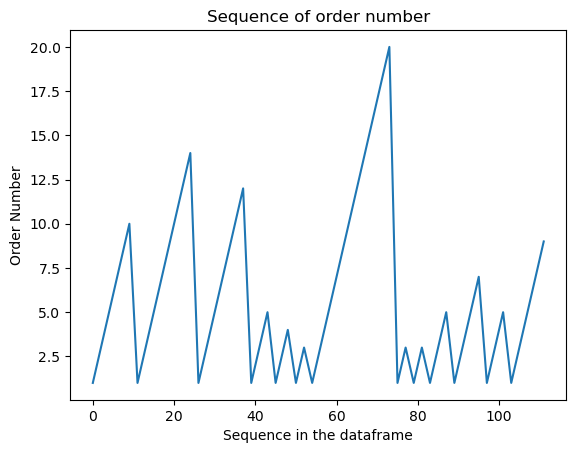

In [20]:
plt.plot(orders.order_number[:100])
plt.title('Sequence of order number')
plt.xlabel('Sequence in the dataframe')
plt.ylabel('Order Number');

The graph illustrates the number of orders made by 100 users. Initially, the first user stands out with 10 order numbers, followed by a noticeable drop indicating the second user. Subsequently, the trend gradually increases, peaking at around 13 or 14 orders. Among the 100 users, there is one individual who surpasses the rest, reaching a remarkable total of 20 orders. To gain further insights, let's analyze the distribution based on the day of the week (dow) and the hours of the day:

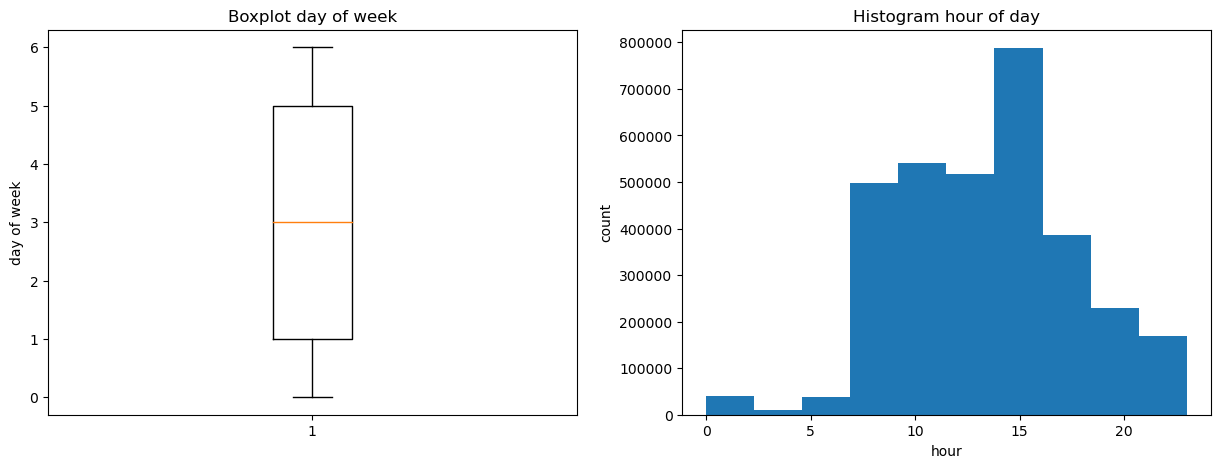

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].boxplot(orders.order_dow)
ax[0].set_title('Boxplot day of week')
ax[0].set_ylabel('day of week')
ax[1].hist(orders.order_hour_of_day)
ax[1].set_title('Histogram hour of day')
ax[1].set_xlabel('hour')
ax[1].set_ylabel('count');

The average purchase is indicated by the orange line, showing that it is day 3. We also can see we have some orders in the hour 0 but the most orders are in hours between 14 and 16. Finally an analysis on days_since_prior_order:

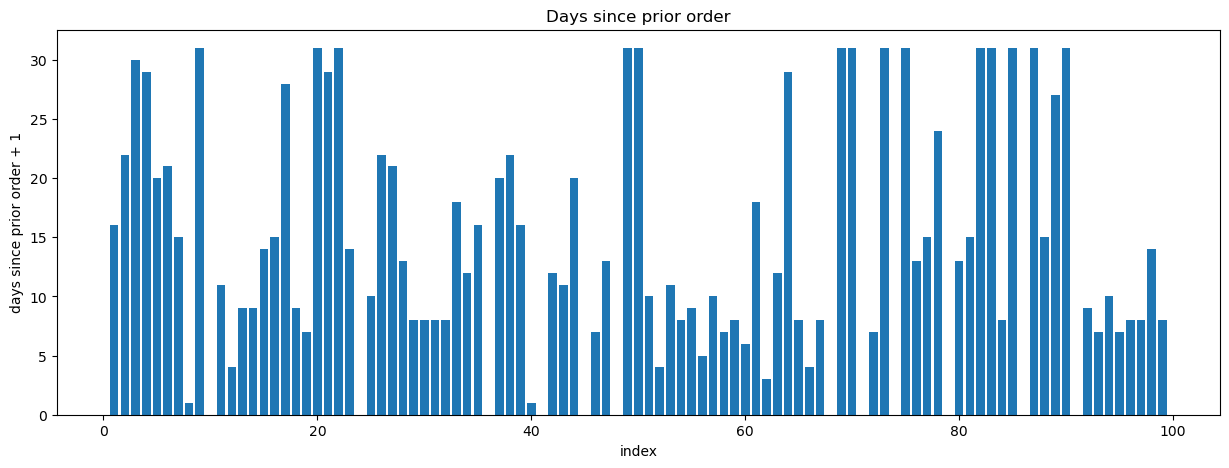

In [22]:
plt.figure(figsize = (15,5))
plt.bar(range(100), orders.days_since_prior_order[:100] + 1)
plt.title('Days since prior order')
plt.xlabel('index')
plt.ylabel('days since prior order + 1');

Here we see how many days later he returned after making the last purchase. Using the first user, we see that it considered NaN and counted 0 days but soon afterwards he said that it returned after 16/17 days for a new purchase. The blanks mean the NaN.

In [23]:
order_products = pd.read_csv('order_products__prior.csv')
order_products.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

In [24]:
order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


The order_id is related to the customer, the add_to_cart_order is the order to which the product is added to the cart, finally the reordered means if the product has already been ordered in previous purchases (1 is when it was previously purchased and 0 the first time you buy the product).

In [25]:
order_products.isna().sum(axis=0)

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

# PERFORMING DATA EXPLORATION

In [26]:
orders_apriori = orders.copy()
orders_user = orders.groupby('user_id')['order_number'].max() #it takes the maximum number of orders placed
orders_user.head()

user_id
1    10
2    14
3    12
4     5
5     4
Name: order_number, dtype: int64

Let's create a data frame that returns not only the user_id and the maximum number of order_number but also the products purchased by the user.

In [27]:
products_user = orders[['order_id', 'user_id']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
                                                                                        on = 'order_id')
products_user

,order_id,user_id,order_size
0,2539329,1,5
1,2398795,1,6
2,473747,1,5
3,2254736,1,5
4,431534,1,8
...,...,...,...
3214869,2558525,206209,3
3214870,2266710,206209,9
3214871,1854736,206209,8
3214872,626363,206209,20


Let's change the data frame where we can view the products by user_id and the total of products purchased:

In [28]:
products_user = products_user.drop('order_id', axis = 1).groupby('user_id')['order_size'].sum()
products_user

user_id
1          59
2         195
3          88
4          18
5          37
         ... 
206205     32
206206    285
206207    223
206208    677
206209    129
Name: order_size, Length: 206209, dtype: int64

Creating a graph to be able to view these results:

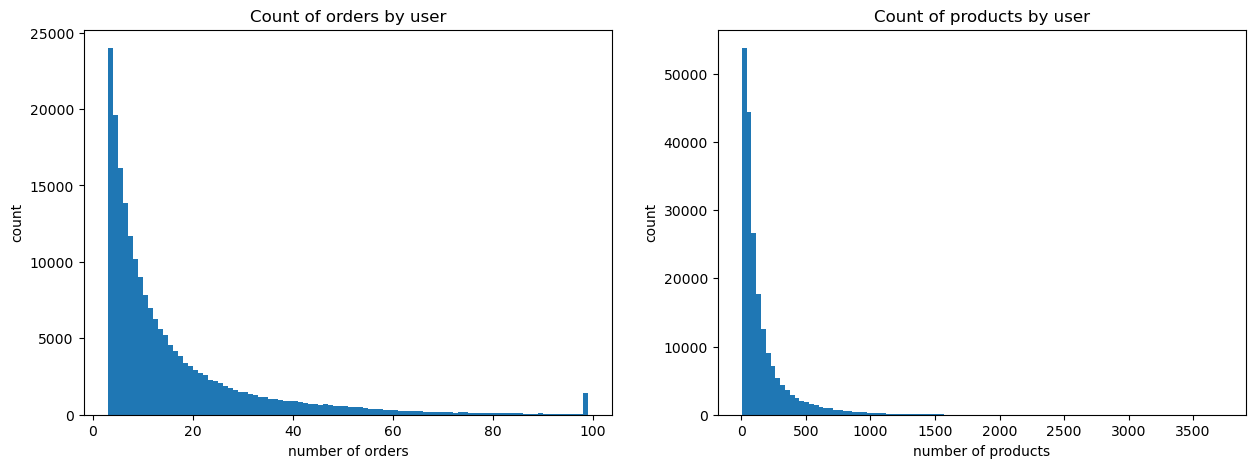

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(orders_user, bins = max(orders_user) - min(orders_user))
ax[0].set_title('Count of orders by user')
ax[0].set_xlabel('number of orders')
ax[0].set_ylabel('count')

ax[1].hist(products_user, bins = 100)
ax[1].set_title('Count of products by user')
ax[1].set_xlabel('number of products')
ax[1].set_ylabel('count');

The first graph illustrates the distribution of customer activity in terms of their number of purchases. It reveals that a significant majority of over 20,000 customers have made approximately 3 purchases in this market. On the other hand, a smaller group of fewer than 5,000 individuals stands out with more than 20 purchases. Notably, there is a distinct peak near the number 100, suggesting a pattern in the database where purchases exceeding 100 are capped at 99 or 100. This leads to an accumulation of individuals who may have made a larger number of purchases, but the data is constrained to the range of up to 100 transactions.

In the second graph, we observe the distribution of customer activity based on the number of products purchased. More specifically, it indicates that over 50,000 customers have bought approximately less than 50 products. In contrast, a smaller subset of fewer than 10,000 customers have made more than 500 purchases.

We will now delete the user_id and order_id columns because they will not be necessary for the creation of the membership rules

In [30]:
orders_apriori.drop(['user_id', 'order_id'], axis = 1, inplace=True)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,2,8,NaN
1,2,3,7,15.0
2,3,3,12,21.0
3,4,4,7,29.0
4,5,4,15,28.0


## By Order Number

In [31]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0


I will create a graph to be able to count the total of order_number:

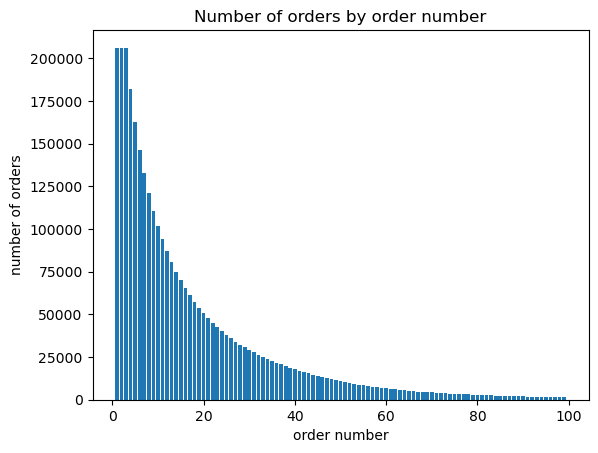

In [32]:
orders_by_order_number = orders.order_number.value_counts()
plt.bar(orders_by_order_number.index, orders_by_order_number)
plt.title('Number of orders by order number')
plt.xlabel('order number')
plt.ylabel('number of orders');

The graph makes it visible that we had over 200000 orders from order_number = 1

In [33]:
#Convert to categorical variables since we will work with membership rules:

def order_number_categorical(order_number):
  if order_number in range(3):
    return 'order_number_1-3'
  if order_number in range(3, 5):
    return 'order_number_4-5'
  if order_number in range(5, 10):
    return 'order_number_6-10'
  if order_number in range(10, 20):
    return 'order_number_11-20'
  if order_number in range(20, 40):
    return 'order_number_21-40'
  if order_number in range(40, 60):
    return 'order_number_41-60'
  if order_number >= 60:
    return 'order_number_60+'

In [34]:
orders_apriori.order_number = orders_apriori.order_number.map(order_number_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,2,8,NaN
1,order_number_1-3,3,7,15.0
2,order_number_4-5,3,12,21.0
3,order_number_4-5,4,7,29.0
4,order_number_6-10,4,15,28.0


## By Day of Week

In [35]:
#Total orders per day of the week:

orders_by_dow = orders.order_dow.value_counts()
orders_by_dow

0    557772
1    556705
2    441955
5    425982
6    418848
3    412400
4    401212
Name: order_dow, dtype: int64

In [36]:
#Total products per day of the week:

products_by_dow = orders[['order_id', 'order_dow']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id')
products_by_dow = products_by_dow.drop('order_id', axis=1).groupby('order_dow')['order_size'].sum()
products_by_dow

order_dow
0    6209666
1    5665856
2    4217798
3    3844117
4    3787215
5    4209533
6    4500304
Name: order_size, dtype: int64

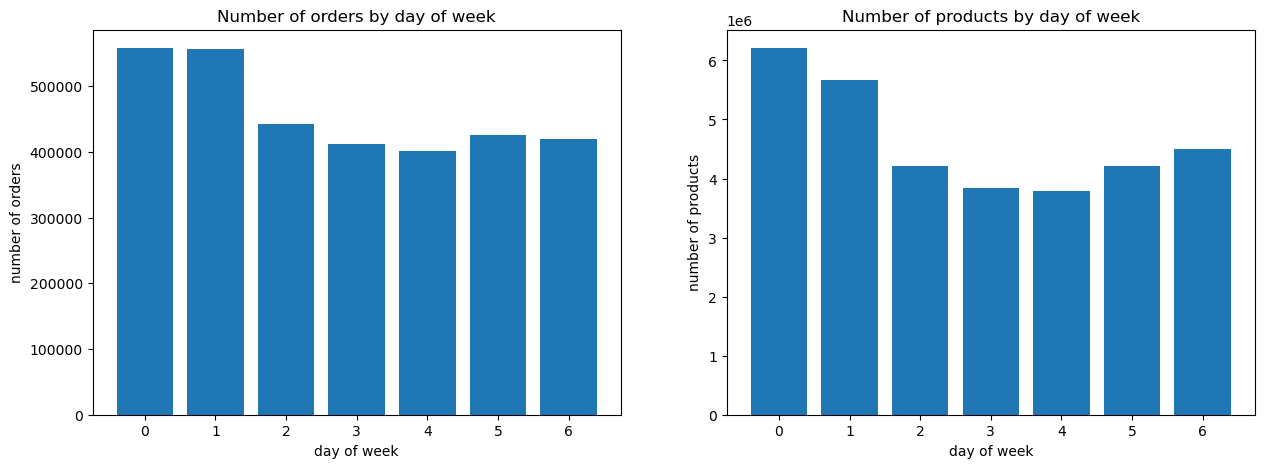

In [37]:
#The results in a more visual way:

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(orders_by_dow.index, orders_by_dow)
ax[0].set_title('Number of orders by day of week')
ax[0].set_xlabel('day of week')
ax[0].set_ylabel('number of orders')

ax[1].bar(products_by_dow.index, products_by_dow)
ax[1].set_title('Number of products by day of week')
ax[1].set_xlabel('day of week')
ax[1].set_ylabel('number of products');

The first graph reveals a significant number of orders on both day 0 and day 1, surpassing 500,000 orders each. However, starting from day 2, the order count gradually decreases, averaging less than 400,500 orders per day.

In the second graph, we observe that on day 0, the number of products ordered exceeds 6 (represented as "le6"). However, from day 2 onwards, the quantity of products ordered drops below 5 (le6).

Now let's create the function for transformation into a categorical variable. The graphs show a great movement on days 0 and 1, so they will be considered weekend (Saturday and Sunday)

In [38]:
def dow_categorical(dow):
    if dow in [0, 1]:
        return 'weekend'
    else:
        return 'weekday'

In [39]:
orders_apriori.order_dow = orders_apriori.order_dow.map(dow_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,8,NaN
1,order_number_1-3,weekday,7,15.0
2,order_number_4-5,weekday,12,21.0
3,order_number_4-5,weekday,7,29.0
4,order_number_6-10,weekday,15,28.0


## By Hours of day

In [40]:
orders_by_hour = orders.order_hour_of_day.value_counts()
orders_by_hour

10    271885
11    268006
15    266132
14    265556
13    261174
12    256206
16    255949
9     243496
17    214080
18    170998
8     168321
19    131620
20     98109
7      86656
21     73436
22     57540
23     37613
6      28792
0      21372
1      11596
5       8972
2       7070
4       5175
3       5120
Name: order_hour_of_day, dtype: int64

Let's create a chart to view the number of orders per hour and the products per hour:

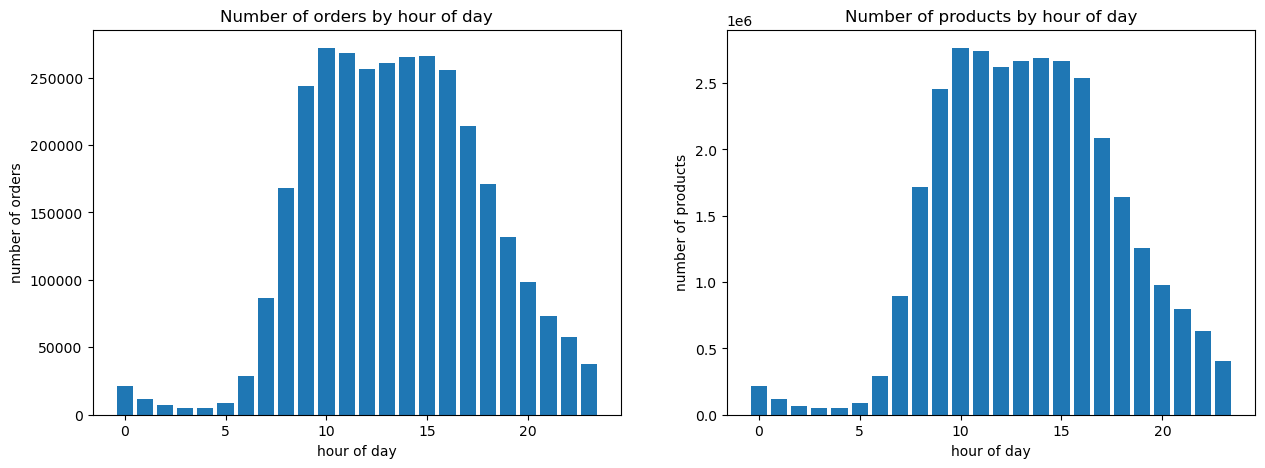

In [41]:
products_by_hour = orders[['order_id', 'order_hour_of_day']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max().rename({'add_to_cart_order': 'order_size'}, axis = 1),
    on = 'order_id')

products_by_hour = products_by_hour.drop('order_id', axis = 1).groupby('order_hour_of_day')['order_size'].sum()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(orders_by_hour.index, orders_by_hour)
ax[0].set_title('Number of orders by hour of day')
ax[0].set_xlabel('hour of day')
ax[0].set_ylabel('number of orders')

ax[1].bar(products_by_hour.index, products_by_hour)
ax[1].set_title('Number of products by hour of day')
ax[1].set_xlabel('hour of day')
ax[1].set_ylabel('number of products');

Graph 1 shows us that the number of orders is more distributed between the hours 9 and 17 hours. And the Graph 2 shows the same. We can see that we don't have so many diferent between the graphs

In [42]:
# conversion to categorical:

def hour_categorical(hour):
  if hour in range(7):
    return 'early_hours'
  if hour in range(7,10):
    return 'hour_' + str(hour)
  if hour in range(10, 17):
    return 'peak_hours'
  if hour in range(17, 24):
    return 'hour_' + str(hour)

In [43]:
orders_apriori.order_hour_of_day = orders_apriori.order_hour_of_day.map(hour_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,hour_8,NaN
1,order_number_1-3,weekday,hour_7,15.0
2,order_number_4-5,weekday,peak_hours,21.0
3,order_number_4-5,weekday,hour_7,29.0
4,order_number_6-10,weekday,peak_hours,28.0


## By Days Since Prior Order

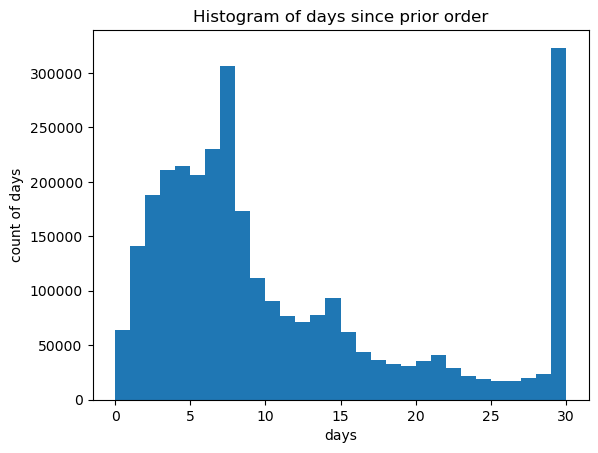

In [44]:
plt.hist(orders.days_since_prior_order, bins = 30)
plt.title('Histogram of days since prior order')
plt.xlabel('days')
plt.ylabel('count of days');

The graph shows us that a large number of customers return after 28 days. It also shows us that there is a big movement in a few days from the previous purchase.

In [45]:
# conversion to categorical:

def interval_categorical(interval):
    if np.isnan(interval):
        return 'first_order'
    elif interval in [7, 14, 21]:
        return 'interval_weekly'
    elif interval == 30:
        return 'interval_30+'
    else:
        return 'interval_others'

In [46]:
orders_apriori.days_since_prior_order = orders_apriori.days_since_prior_order.map(interval_categorical)
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,hour_8,first_order
1,order_number_1-3,weekday,hour_7,interval_others
2,order_number_4-5,weekday,peak_hours,interval_weekly
3,order_number_4-5,weekday,hour_7,interval_others
4,order_number_6-10,weekday,peak_hours,interval_others


## By Order Products

Reordered Products: Create a dictionary to associate ids with product names.

In [47]:
products_id_to_name = {k: v for k, v in zip(products.product_id, products.product_name)}
print(products_id_to_name)

{1: 'Chocolate Sandwich Cookies', 2: 'All-Seasons Salt', 3: 'Robust Golden Unsweetened Oolong Tea', 4: 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce', 5: 'Green Chile Anytime Sauce', 6: 'Dry Nose Oil', 7: 'Pure Coconut Water With Orange', 8: "Cut Russet Potatoes Steam N' Mash", 9: 'Light Strawberry Blueberry Yogurt', 10: 'Sparkling Orange Juice & Prickly Pear Beverage', 11: 'Peach Mango Juice', 12: 'Chocolate Fudge Layer Cake', 13: 'Saline Nasal Mist', 14: 'Fresh Scent Dishwasher Cleaner', 15: 'Overnight Diapers Size 6', 16: 'Mint Chocolate Flavored Syrup', 17: 'Rendered Duck Fat', 18: 'Pizza for One Suprema  Frozen Pizza', 19: 'Gluten Free Quinoa Three Cheese & Mushroom Blend', 20: 'Pomegranate Cranberry & Aloe Vera Enrich Drink', 21: 'Small & Medium Dental Dog Treats', 22: 'Fresh Breath Oral Rinse Mild Mint', 23: 'Organic Turkey Burgers', 24: 'Tri-Vi-Sol® Vitamins A-C-and D Supplement Drops for Infants', 25: 'Salted Caramel Lean Protein & Fiber Bar', 26: 'Fancy F

In [48]:
#create a new data frame:

order_products_names = order_products.copy()
order_products_names['product_name'] = order_products_names.product_id.map(lambda x: products_id_to_name[x])
order_products_names

,order_id,product_id,add_to_cart_order,reordered,product_name
0,2,33120,1,1,Organic Egg Whites
1,2,28985,2,1,Michigan Organic Kale
2,2,9327,3,0,Garlic Powder
3,2,45918,4,1,Coconut Butter
4,2,30035,5,0,Natural Sweetener
...,...,...,...,...,...
32434484,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent
32434485,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter
32434486,3421083,4600,8,0,All Natural French Toast Sticks
32434487,3421083,24852,9,1,Banana


In [49]:
#count how many times the product was purchased for the first time and how many times a product was repurchased:

reorder_proportion = pd.crosstab(order_products_names.product_name, order_products_names.reordered)
reorder_proportion

reordered,0,1
product_name,,
#2 Coffee Filters,520,257
#2 Cone White Coffee Filters,10,3
#2 Mechanical Pencils,8,0
#4 Natural Brown Coffee Filters,152,89
& Go! Hazelnut Spread + Pretzel Sticks,77,87
...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,20,17
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,36,19
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,37,31


In this case, 0 indicates the number of times the product was purchased for the first time and 1 indicates the number of times it was repurchased. Ordering the products that were most purchased for the first time:

In [50]:
reorder_proportion.sort_values(by = 0, ascending=False)

reordered,0,1
product_name,,
Banana,73956,398609
Bag of Organic Bananas,63537,315913
Organic Strawberries,58838,205845
Organic Baby Spinach,55037,186884
Large Lemon,46402,106255
...,...,...
Brut Prosecco,1,0
Smooth & Silky Head and Shoulders Smooth & Silky 2-in-1 Dandruff Shampoo + Conditioner 13.5 Fl Oz Female Hair Care,1,0
Gluten Free Pantry Sugar Cookie Mix,1,1


Ordering products that have been purchased more than once:

In [51]:
reorder_proportion.sort_values(by = 1, ascending=False)

reordered,0,1
product_name,,
Banana,73956,398609
Bag of Organic Bananas,63537,315913
Organic Strawberries,58838,205845
Organic Baby Spinach,55037,186884
Organic Hass Avocado,43453,170131
...,...,...
Decorating Green Cake Icing,21,0
Lemon Ice Tea Liquid,4,0
"Decorating Gel, Red",7,0


In percentage:

In [52]:
reorder_proportion['total'] = reorder_proportion.sum(axis = 1)
reorder_proportion['0.perc'] = reorder_proportion[0] / reorder_proportion['total']
reorder_proportion['1.perc'] = reorder_proportion[1] / reorder_proportion['total']
reorder_proportion.head()

reordered,0,1,total,0.perc,1.perc
product_name,,,,,
#2 Coffee Filters,520,257,777,0.669241,0.330759
#2 Cone White Coffee Filters,10,3,13,0.769231,0.230769
#2 Mechanical Pencils,8,0,8,1.000000,0.000000
#4 Natural Brown Coffee Filters,152,89,241,0.630705,0.369295
& Go! Hazelnut Spread + Pretzel Sticks,77,87,164,0.469512,0.530488


Products that were first purchased and never repurchased:

In [53]:
reorder_proportion.sort_values(by = ['0.perc', 'total'], ascending = False)[['0.perc', 'total']]

reordered,0.perc,total
product_name,,
Vicks DayQuil and NyQuil Cold & Flu Relief Combo,1.000000,88
Organic Castor Oil Skin Care,1.000000,67
Organic Whole Rosemary,1.000000,63
Lemon Verbena Scent Glass Cleaner,1.000000,53
Organic Lemongrass,1.000000,52
...,...,...
Soy Powder Infant Formula,0.085714,35
Chocolate Love Bar,0.079208,101
Orange Energy Shots,0.076923,13


As it is a percentage, here the value 1 returns the information that 100% of the times it was only purchased for the first time.

Seeing the products that after the first purchase, are always bought again:

In [54]:
reorder_proportion.sort_values(by = ['1.perc', 'total'], ascending = False)[['1.perc', 'total']]

reordered,1.perc,total
product_name,,
Raw Veggie Wrappers,0.941176,68
Serenity Ultimate Extrema Overnight Pads,0.931034,87
Orange Energy Shots,0.923077,13
Chocolate Love Bar,0.920792,101
Soy Powder Infant Formula,0.914286,35
...,...,...
Vitality Chicken Breasts with Flaxseed & Vitamins Dog Treats,0.000000,1
Vitamin D Gummies,0.000000,1
Wicked Good No-Fry Wing Marinade,0.000000,1


The most purchased products:

In [55]:
reorder_proportion.total.sort_values(ascending=False)

product_name
Banana                                                    472565
Bag of Organic Bananas                                    379450
Organic Strawberries                                      264683
Organic Baby Spinach                                      241921
Organic Hass Avocado                                      213584
                                                           ...  
Pure Performance Restorative Shampoo Chamomile & Honey         1
Lindor Peppermint White Chocolate Truffles                     1
Dynostix Rawhide Chew With Meat                                1
Max White With Polishing Star Soft Toothbrush                  1
Cajun Sides Dirty Rice                                         1
Name: total, Length: 49677, dtype: int64

Products not ordered: is there a product that was never purchased?

In [56]:
products_bought = sorted(order_products.product_id.unique())
print(len(products_bought), len(products))

49677 49688


The first value returns the quantity of products ordered. The second takes the product toal in the data frame. Let's find out which are the 11 products that were not purchased!

In [57]:
products_not_bought = list(products.product_id[~products.product_id.isin(products_bought)])
products_not_bought

[3630, 3718, 7045, 25383, 27499, 36233, 37703, 43725, 45971, 46625, 49540]

In [58]:
#the name of the products not bought
[products_id_to_name[product] for product in products_not_bought]

['Protein Granola Apple Crisp',
 'Wasabi Cheddar Spreadable Cheese',
 'Unpeeled Apricot Halves in Heavy Syrup',
 'Chocolate Go Bites',
 'Non-Dairy Coconut Seven Layer Bar',
 'Water With Electrolytes',
 'Ultra Sun Blossom Liquid 90 loads Fabric Enhancers',
 'Sweetart Jelly Beans',
 '12 Inch Taper Candle White',
 'Single Barrel Kentucky Straight Bourbon Whiskey',
 'Pure Squeezed  Lemonade']

I will do a security check just to see if all products are registered:

In [59]:
products_not_registered = list(pd.Series(products_bought)[~pd.Series(products_bought).isin(products.product_id)])
print(len(products_not_registered), products_not_registered)

0 []


Market Basket: to do a study on the size of the market basket and how often it happens

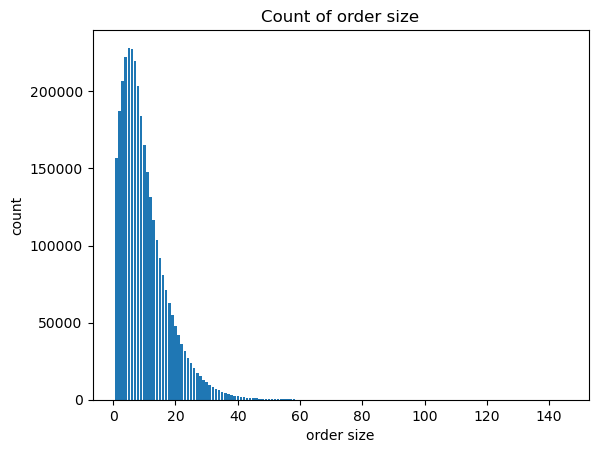

In [60]:
cart_size = order_products.groupby('order_id')['add_to_cart_order'].max()
cart_size = cart_size.value_counts()
plt.bar(cart_size.index, cart_size)
plt.title('Count of order size')
plt.xlabel('order size')
plt.ylabel('count');


We can see that more than 200000 have an order_size between 5 and 15. And less than 50000 have an order_size that is more than 20.



Most Frequent Products: now we will link the id with the add_to_cart_order

In [61]:
add_to_cart = pd.crosstab(order_products_names.product_name, order_products_names.add_to_cart_order)
add_to_cart

add_to_cart_order,1,2,3,4,5,6,7,8,9,10,...,136,137,138,139,140,141,142,143,144,145
product_name,,,,,,,,,,,,,,,,,,,,,
#2 Coffee Filters,86,61,56,52,38,42,41,50,41,40,...,0,0,0,0,0,0,0,0,0,0
#2 Cone White Coffee Filters,4,0,1,0,2,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
#2 Mechanical Pencils,3,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#4 Natural Brown Coffee Filters,24,15,12,18,16,16,13,9,11,6,...,0,0,0,0,0,0,0,0,0,0
& Go! Hazelnut Spread + Pretzel Sticks,12,7,9,9,12,12,12,9,13,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,3,5,2,3,5,5,2,2,3,1,...,0,0,0,0,0,0,0,0,0,0
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,5,5,4,1,6,6,3,1,3,3,...,0,0,0,0,0,0,0,0,0,0
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,6,4,7,5,7,8,9,6,2,1,...,0,0,0,0,0,0,0,0,0,0


The table shows the number of times the product was added to the cart in that order.

Let's create a for to get a sense of the orders to which products are added to the cart:

In [62]:
for i in range(1,6):
    print('ORDER = ', i)
    print(add_to_cart.sort_values(by = i, ascending=False)[i][:5])
    print('\n')

ORDER =  1
product_name
Banana                    110916
Bag of Organic Bananas     78988
Organic Whole Milk         30927
Organic Strawberries       27975
Organic Hass Avocado       24116
Name: 1, dtype: int64


ORDER =  2
product_name
Banana                    80432
Bag of Organic Bananas    64337
Organic Strawberries      29754
Organic Hass Avocado      26517
Organic Baby Spinach      25025
Name: 2, dtype: int64


ORDER =  3
product_name
Banana                    58577
Bag of Organic Bananas    48972
Organic Strawberries      27809
Organic Baby Spinach      24297
Organic Hass Avocado      24212
Name: 3, dtype: int64


ORDER =  4
product_name
Banana                    43653
Bag of Organic Bananas    36955
Organic Strawberries      25242
Organic Baby Spinach      22733
Organic Hass Avocado      21001
Name: 4, dtype: int64


ORDER =  5
product_name
Banana                    33647
Bag of Organic Bananas    28897
Organic Strawberries      22137
Organic Baby Spinach      20308
Organic Has

It shows the products that are placed first in the cart.

# ASSOCIATION RULES

## Apriori Algorithm

Apriori is an algorithm used to identify frequent item sets (in our case, item pairs). It does so using a "bottom up" approach, first identifying individual items that satisfy a minimum occurence threshold. It then extends the item set, adding one item at a time and checking if the resulting item set still satisfies the specified threshold. The algorithm stops when there are no more items to add that meet the minimum occurrence requirement.

## Association Rules Mining

Once the item sets have been generated using apriori, we can start mining association rules. Given that we are only looking at item sets of size 2, the association rules we will generate will be of the form {A} -> {B}. One common application of these rules is in the domain of recommender systems, where customers who purchased item A are recommended item B.

Here are 3 key metrics to consider when evaluating association rules:

### 1. Support

Support measures the frequency or popularity of an itemset in a dataset. It represents the proportion of transactions in the dataset that contain a specific itemset. Support is calculated by dividing the number of transactions containing the itemset by the total number of transactions. It helps identify frequently occurring itemsets.

### 2. Confidence

Confidence measures the reliability or strength of an association rule. It represents the conditional probability that an itemset B is purchased given that another itemset A is purchased. Confidence is calculated by dividing the support of the combined itemset (A and B) by the support of the antecedent itemset (A). It helps determine the likelihood of purchasing related items together.

### 3. Lift

Lift is a measure of the strength of an association rule that indicates how much more likely itemset B is purchased when itemset A is already purchased, compared to the likelihood of purchasing B without considering A. Lift is calculated by dividing the confidence of the rule (A → B) by the support of B. It helps identify associations that are not simply due to chance or coincidence.

First, I will use Apriori for Shopping Habits to later make assostions with the products!

Shopping Habits:

In [63]:
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,weekday,hour_8,first_order
1,order_number_1-3,weekday,hour_7,interval_others
2,order_number_4-5,weekday,peak_hours,interval_weekly
3,order_number_4-5,weekday,hour_7,interval_others
4,order_number_6-10,weekday,peak_hours,interval_others


In [64]:
orders_apriori.shape

(3214874, 4)

In order to use the Apriori algorithm it will be necessary to transform the data frame into a list.

In [65]:
trans = []
for i in range(orders_apriori.shape[0]):
    trans.append([str(orders_apriori.values[i, j]) for j in range(orders_apriori.shape[1])])

In [66]:
trans[:4]

[['order_number_1-3', 'weekday', 'hour_8', 'first_order'],
 ['order_number_1-3', 'weekday', 'hour_7', 'interval_others'],
 ['order_number_4-5', 'weekday', 'peak_hours', 'interval_weekly'],
 ['order_number_4-5', 'weekday', 'hour_7', 'interval_others']]

Now on the list we can start creating some rules to be able to notice possible patterns.

In [67]:
start = datetime.now()
rules = apriori(trans, min_support = 0.005, min_confidence = 0.2, min_lift = 2)
results = list(rules)
print('Execution time: ', datetime.now() - start)

Execution time:  0:01:20.573655


In [68]:
results[0]

RelationRecord(items=frozenset({'first_order', 'order_number_1-3'}), support=0.06414217166831422, ordered_statistics=[OrderedStatistic(items_base=frozenset({'first_order'}), items_add=frozenset({'order_number_1-3'}), confidence=1.0, lift=7.795183527392111), OrderedStatistic(items_base=frozenset({'order_number_1-3'}), items_add=frozenset({'first_order'}), confidence=0.5, lift=7.795183527392111)])

In [69]:
#more detailed analysis of the rule:
results[0][0]

frozenset({'first_order', 'order_number_1-3'})

In [70]:
#item 0, position 1:
results[0][1]

0.06414217166831422

In [71]:
#create a vriable r with results in position 0 and position 2:
r = results[0][2]
r

[OrderedStatistic(items_base=frozenset({'first_order'}), items_add=frozenset({'order_number_1-3'}), confidence=1.0, lift=7.795183527392111),
 OrderedStatistic(items_base=frozenset({'order_number_1-3'}), items_add=frozenset({'first_order'}), confidence=0.5, lift=7.795183527392111)]

In [72]:
#it will return the fist rule
r[0]

OrderedStatistic(items_base=frozenset({'first_order'}), items_add=frozenset({'order_number_1-3'}), confidence=1.0, lift=7.795183527392111)

In [73]:
#it will return the second rule
r[1]


OrderedStatistic(items_base=frozenset({'order_number_1-3'}), items_add=frozenset({'first_order'}), confidence=0.5, lift=7.795183527392111)

In [74]:
#it return the fist rule and the confidence, after it will return the fist rule and the lift:
r[0][2], r[0][3]

(1.0, 7.795183527392111)

Now we create a function to transform the data in a data frame to get easier to make a best avaliation of the each rules it was created!

In [75]:
A = []
B = []
support = []
confidence = []
lift = []

for result in results:
  s = result[1]
  result_rules = result[2]
  for result_rule in result_rules:
    a = list(result_rule[0])
    b = list(result_rule[1])
    c = result_rule[2]
    l = result_rule[3]
    A.append(a)
    B.append(b)
    support.append(s)
    confidence.append(c)
    lift.append(l) 

rules_df = pd.DataFrame({
    'A': A,
    'B': B,
    'support': support,
    'confidence': confidence,
    'lift': lift
})

rules_df = rules_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
len(rules_df)

38

It returned 38 rules to us

In [76]:
A[0], B[0], A[1], B[1]

(['first_order'], ['order_number_1-3'], ['order_number_1-3'], ['first_order'])

The data frame improves our view of the rules:

In [77]:
rules_df

,A,B,support,confidence,lift
0,"[first_order, peak_hours]","[order_number_1-3, weekend]",0.013600,0.367834,8.057873
1,"[weekend, order_number_1-3]","[first_order, peak_hours]",0.013600,0.297930,8.057873
2,"[first_order, weekend]","[peak_hours, order_number_1-3]",0.013600,0.594952,8.047623
3,"[weekend, order_number_1-3]",[first_order],0.022859,0.500763,7.807082
4,[first_order],"[order_number_1-3, weekend]",0.022859,0.356386,7.807082
5,[first_order],"[order_number_1-3, peak_hours, weekend]",0.013600,0.212032,7.799732
6,"[weekend, peak_hours, order_number_1-3]",[first_order],0.013600,0.500292,7.799732
7,"[peak_hours, order_number_1-3]",[first_order],0.036974,0.500126,7.797151
8,[first_order],"[peak_hours, order_number_1-3]",0.036974,0.576435,7.797151
9,[first_order],"[peak_hours, weekday, order_number_1-3]",0.023374,0.364402,7.795650


Here it is much easier to visualize. Let's look at rule 0: peak_hours andfirst_order, that is, during peak hours and first purchase and their relationship in being weekend and being betweenorder_number_1-3. Here we see the relationship between peak hours being the first purchase and occurring on a weekend where purchases are between 1-3. Let us now look at rule 33, in an interval of more than 30 days and its relationship with being the 4th and 5th purchase. Here shows us more about after 30 days the customers come back to make their purchases 4 or 5 (returning for the fourth or fifth time to make another purchase).

Association between products: Let's repeat the Apriori algorithm, but now manually, realizing the association of products! As we have a large number of products and users, it is easier to do it manually because it would take a long time just setting up the database.

Due to the size of the data, we will only take a sample of 5000 products, even to avoid problems of lack of memory on the machine.

In [78]:
transactions_df = order_products[['order_id', 'product_id']][:5000]
transactions_df

,order_id,product_id
0,2,33120
1,2,28985
2,2,9327
3,2,45918
4,2,30035
...,...,...
4995,528,40897
4996,528,22182
4997,528,44799
4998,529,41844


In [79]:
n_orders = len(set(transactions_df.order_id))
n_products = len(set(transactions_df.product_id))
print(n_orders, n_products)

499 2809


We have 499 orders and 2809 products.

I will create a dataframe that shows the frequency of products in transactions:

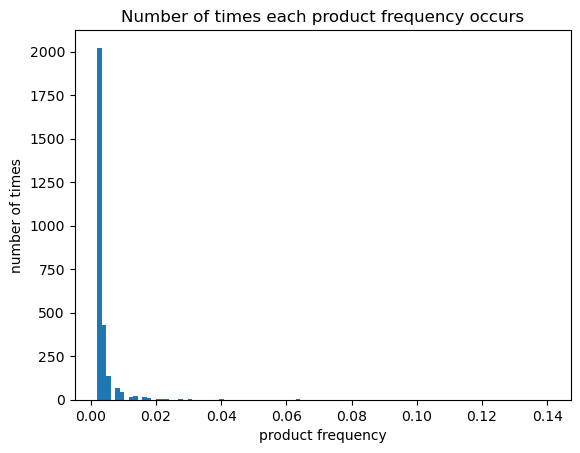

In [80]:
product_frequency = transactions_df.product_id.value_counts() / n_orders
plt.hist(product_frequency, bins = 100)
plt.title('Number of times each product frequency occurs')
plt.xlabel('product frequency')
plt.ylabel('number of times');

The graph shows us that more than 1750 products appear less than 0.02 times. And that less than 250 products appear more than 0.02 times in transactions.

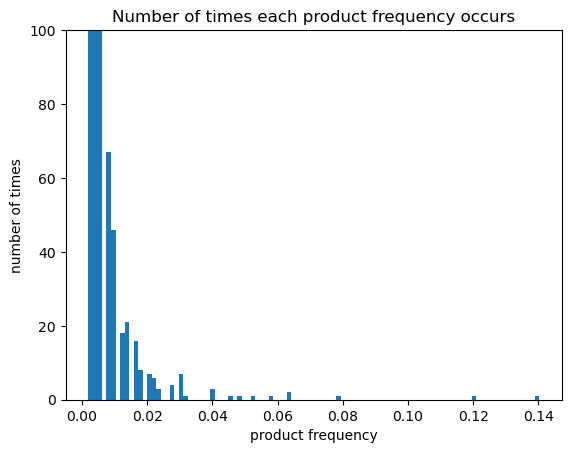

In [81]:
#a zoom:

plt.hist(product_frequency, bins = 100)
plt.title('Number of times each product frequency occurs')
plt.xlabel('product frequency')
plt.ylabel('number of times')
plt.ylim([0, 100]);

We will now do an analysis to be able to later remove the products that appear few times. We will only search for products that appear at least 4 times, and for that you will need a support of 0.01 (0.01 * 499 = 4.99, we can round to 5).

In [82]:
min_support = 0.01
products_apriori = product_frequency[product_frequency >= min_support]
print(products_apriori)

24852    0.140281
13176    0.120240
21903    0.078156
47209    0.064128
21137    0.064128
           ...   
35503    0.010020
12276    0.010020
19019    0.010020
44142    0.010020
47144    0.010020
Name: product_id, Length: 149, dtype: float64


With this filter, we were able to reduce from 2809 products to 149! Let's create a data frame to see better:

In [83]:
transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
transactions_apriori

,order_id,product_id
0,2,33120
1,2,28985
5,2,17794
10,3,24838
12,3,21903
...,...,...
4975,526,1940
4982,527,49235
4988,527,21903
4989,527,35939


In [84]:
order_sizes = transactions_apriori.order_id.value_counts()
order_sizes

431    15
493    15
265    14
426    14
359    13
       ..
156     1
427     1
65      1
155     1
115     1
Name: order_id, Length: 399, dtype: int64

The order_size 431 has 15 products.

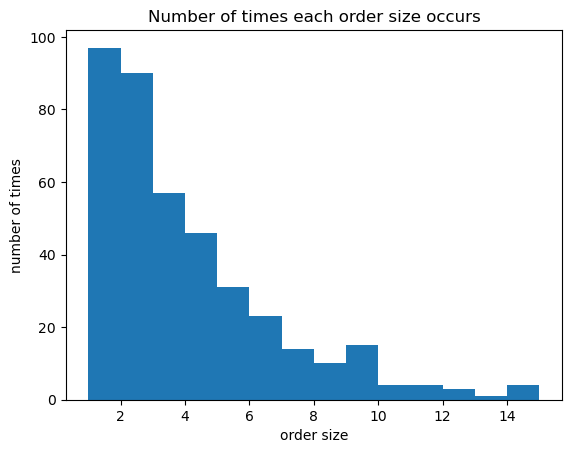

In [85]:
plt.hist(order_sizes, bins = max(order_sizes) - min(order_sizes))
plt.title('Number of times each order size occurs')
plt.xlabel('order size')
plt.ylabel('number of times');

Most orders only have 1 or 2 products! Less than 20 orders you have 8 products! It's kind of weird and there's no point in making membership rules with just 1 product. So let's delete orders that only have a single product.

In [86]:
min_lenght = 2
orders_apriori = order_sizes[order_sizes >= min_lenght]
print(orders_apriori)

431    15
493    15
265    14
426    14
359    13
       ..
307     2
305     2
126     2
127     2
326     2
Name: order_id, Length: 302, dtype: int64


In [87]:
transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
transactions_apriori

,order_id,product_id
0,2,33120
1,2,28985
5,2,17794
10,3,24838
12,3,21903
...,...,...
4975,526,1940
4982,527,49235
4988,527,21903
4989,527,35939


Let's make all possible combinations:

In [88]:
transactions_by_order = transactions_apriori.groupby('order_id')['product_id']
for order_id, order_list in transactions_by_order:
  print('Order_id:', order_id, '\nOrder_list: ', list(order_list))
  product_combinations = combinations(order_list, 2)
  print('Product combinations:')
  print([i for i in product_combinations])
  print('\n')

Order_id: 2 
Order_list:  [33120, 28985, 17794]
Product combinations:
[(33120, 28985), (33120, 17794), (28985, 17794)]


Order_id: 3 
Order_list:  [24838, 21903, 46667, 17461]
Product combinations:
[(24838, 21903), (24838, 46667), (24838, 17461), (21903, 46667), (21903, 17461), (46667, 17461)]


Order_id: 5 
Order_list:  [13176, 27966, 23909, 6184, 37011, 47209]
Product combinations:
[(13176, 27966), (13176, 23909), (13176, 6184), (13176, 37011), (13176, 47209), (27966, 23909), (27966, 6184), (27966, 37011), (27966, 47209), (23909, 6184), (23909, 37011), (23909, 47209), (6184, 37011), (6184, 47209), (37011, 47209)]


Order_id: 9 
Order_list:  [21405, 14992, 31506, 432]
Product combinations:
[(21405, 14992), (21405, 31506), (21405, 432), (14992, 31506), (14992, 432), (31506, 432)]


Order_id: 10 
Order_list:  [24852, 31717, 47766, 4605, 21137, 27156, 14992, 49235]
Product combinations:
[(24852, 31717), (24852, 47766), (24852, 4605), (24852, 21137), (24852, 27156), (24852, 14992), (24852

In this code it returns the order id, the products and the combinations of those products. Now let's put all the combinations together and then count the number of occurrences:

In [89]:
def product_combinations(transactions_df, max_length = 5):
  transactions_by_order = transactions_df.groupby('order_id')['product_id']
  max_length_reference = max_length
  for order_id, order_list in transactions_by_order:
    max_length = min(max_length_reference, len(order_list))
    order_list = sorted(order_list)
    for l in range(2, max_length + 1):
      product_combinations = combinations(order_list, l)
      for combination in product_combinations:
        yield combination

In [90]:
combs = product_combinations(transactions_apriori)
combs

<generator object product_combinations at 0x0000018C89E156D0>

In [91]:
#view all combinations of products that have been generated:

for _ in range(100):
  print(next(iter(combs)))

(17794, 28985)
(17794, 33120)
(28985, 33120)
(17794, 28985, 33120)
(17461, 21903)
(17461, 24838)
(17461, 46667)
(21903, 24838)
(21903, 46667)
(24838, 46667)
(17461, 21903, 24838)
(17461, 21903, 46667)
(17461, 24838, 46667)
(21903, 24838, 46667)
(17461, 21903, 24838, 46667)
(6184, 13176)
(6184, 23909)
(6184, 27966)
(6184, 37011)
(6184, 47209)
(13176, 23909)
(13176, 27966)
(13176, 37011)
(13176, 47209)
(23909, 27966)
(23909, 37011)
(23909, 47209)
(27966, 37011)
(27966, 47209)
(37011, 47209)
(6184, 13176, 23909)
(6184, 13176, 27966)
(6184, 13176, 37011)
(6184, 13176, 47209)
(6184, 23909, 27966)
(6184, 23909, 37011)
(6184, 23909, 47209)
(6184, 27966, 37011)
(6184, 27966, 47209)
(6184, 37011, 47209)
(13176, 23909, 27966)
(13176, 23909, 37011)
(13176, 23909, 47209)
(13176, 27966, 37011)
(13176, 27966, 47209)
(13176, 37011, 47209)
(23909, 27966, 37011)
(23909, 27966, 47209)
(23909, 37011, 47209)
(27966, 37011, 47209)
(6184, 13176, 23909, 27966)
(6184, 13176, 23909, 37011)
(6184, 13176, 23909,

In [92]:
#how often each of these combinations appears:

combs = product_combinations(transactions_apriori)
counter = Counter(combs).items()
combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
combinations_frequency = combinations_count / n_orders
print(combinations_frequency)

(17794, 28985)                  0.006012
(17794, 33120)                  0.002004
(28985, 33120)                  0.002004
(17794, 28985, 33120)           0.002004
(17461, 21903)                  0.004008
                                  ...   
(17461, 21903, 35939)           0.002004
(17461, 21903, 49235)           0.002004
(17461, 35939, 49235)           0.002004
(21903, 35939, 49235)           0.002004
(17461, 21903, 35939, 49235)    0.002004
Length: 41452, dtype: float64


In [93]:
combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_lenght]
print(combinations_apriori, len(combinations_apriori))

(13176, 27966)    0.018036
(13176, 47209)    0.018036
(27966, 47209)    0.012024
(21137, 24852)    0.014028
(21137, 47766)    0.012024
(24852, 47766)    0.012024
(21903, 24852)    0.028056
(13176, 17794)    0.010020
(13176, 43352)    0.010020
(21903, 22935)    0.010020
(16797, 39275)    0.012024
(16797, 43352)    0.010020
(24852, 49683)    0.012024
(24852, 47626)    0.014028
(37646, 47209)    0.012024
(21903, 47209)    0.012024
(21137, 21903)    0.010020
(21137, 47209)    0.010020
(13176, 22935)    0.014028
(24852, 28204)    0.016032
(24852, 45066)    0.016032
(1158, 21903)     0.010020
(9076, 24852)     0.014028
(16797, 24852)    0.010020
(13176, 21137)    0.014028
(24852, 26209)    0.014028
(12341, 16797)    0.010020
dtype: float64 27


Let's create a code so that it can perform the combinations for the entire database:

In [94]:
A = []
B = []
AB = []
for c in combinations_apriori.index:
  c_length = len(c)
  for l in range(1, c_length):
    comb = combinations(c, l)
    for a in comb:
      AB.append(c)
      b = list(c)
      for e in a:
        b.remove(e)
      b = tuple(b)
      if len(a) == 1:
        a = a[0]
      A.append(a)
      if len(b) == 1:
        b = b[0]
      B.append(b)

In [95]:
apriori_df = pd.DataFrame({'A': A,
                           'B': B,
                           'AB': AB})

In [96]:
apriori_df.head()

,A,B,AB
0,13176,27966,"(13176, 27966)"
1,27966,13176,"(13176, 27966)"
2,13176,47209,"(13176, 47209)"
3,47209,13176,"(13176, 47209)"
4,27966,47209,"(27966, 47209)"


In [97]:
products_apriori

24852    0.140281
13176    0.120240
21903    0.078156
47209    0.064128
21137    0.064128
           ...   
35503    0.010020
12276    0.010020
19019    0.010020
44142    0.010020
47144    0.010020
Name: product_id, Length: 149, dtype: float64

In [98]:
combinations_frequency

(17794, 28985)                  0.006012
(17794, 33120)                  0.002004
(28985, 33120)                  0.002004
(17794, 28985, 33120)           0.002004
(17461, 21903)                  0.004008
                                  ...   
(17461, 21903, 35939)           0.002004
(17461, 21903, 49235)           0.002004
(17461, 35939, 49235)           0.002004
(21903, 35939, 49235)           0.002004
(17461, 21903, 35939, 49235)    0.002004
Length: 41452, dtype: float64

In [99]:
support = {**{k: v for k, v in products_apriori.items()},
           **{k: v for k, v in combinations_frequency.items()}}
support

{24852: 0.1402805611222445,
 13176: 0.12024048096192384,
 21903: 0.0781563126252505,
 47209: 0.06412825651302605,
 21137: 0.06412825651302605,
 16797: 0.05811623246492986,
 47626: 0.052104208416833664,
 47766: 0.04809619238476954,
 22935: 0.04609218436873747,
 27966: 0.04008016032064128,
 45066: 0.04008016032064128,
 26209: 0.04008016032064128,
 27845: 0.03206412825651302,
 43352: 0.03006012024048096,
 21616: 0.03006012024048096,
 44632: 0.03006012024048096,
 49683: 0.03006012024048096,
 28204: 0.03006012024048096,
 24964: 0.03006012024048096,
 17794: 0.03006012024048096,
 31717: 0.028056112224448898,
 19660: 0.028056112224448898,
 39275: 0.028056112224448898,
 26604: 0.028056112224448898,
 4605: 0.02404809619238477,
 5876: 0.02404809619238477,
 33731: 0.02404809619238477,
 22825: 0.022044088176352707,
 37646: 0.022044088176352707,
 45007: 0.022044088176352707,
 8518: 0.022044088176352707,
 9076: 0.022044088176352707,
 30391: 0.022044088176352707,
 30489: 0.02004008016032064,
 42265: 0

In [100]:
#updating thevapriori_df with the news combinations:

apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
apriori_df

,A,B,AB,support_A,support_B,support_AB
0,13176,27966,"(13176, 27966)",0.120240,0.040080,0.018036
1,27966,13176,"(13176, 27966)",0.040080,0.120240,0.018036
2,13176,47209,"(13176, 47209)",0.120240,0.064128,0.018036
3,47209,13176,"(13176, 47209)",0.064128,0.120240,0.018036
4,27966,47209,"(27966, 47209)",0.040080,0.064128,0.012024
5,47209,27966,"(27966, 47209)",0.064128,0.040080,0.012024
6,21137,24852,"(21137, 24852)",0.064128,0.140281,0.014028
7,24852,21137,"(21137, 24852)",0.140281,0.064128,0.014028
8,21137,47766,"(21137, 47766)",0.064128,0.048096,0.012024
9,47766,21137,"(21137, 47766)",0.048096,0.064128,0.012024


In [101]:
apriori_df.drop('AB', axis = 1, inplace=True)
apriori_df.head()

,A,B,support_A,support_B,support_AB
0,13176,27966,0.120240,0.040080,0.018036
1,27966,13176,0.040080,0.120240,0.018036
2,13176,47209,0.120240,0.064128,0.018036
3,47209,13176,0.064128,0.120240,0.018036
4,27966,47209,0.040080,0.064128,0.012024


In [102]:
#generating confidence and lift:

apriori_df['confidence'] = apriori_df.support_AB / apriori_df.support_A
apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
apriori_df

,A,B,support_A,support_B,support_AB,confidence,lift
0,13176,27966,0.120240,0.040080,0.018036,0.150000,3.742500
1,27966,13176,0.040080,0.120240,0.018036,0.450000,3.742500
2,13176,47209,0.120240,0.064128,0.018036,0.150000,2.339063
3,47209,13176,0.064128,0.120240,0.018036,0.281250,2.339063
4,27966,47209,0.040080,0.064128,0.012024,0.300000,4.678125
5,47209,27966,0.064128,0.040080,0.012024,0.187500,4.678125
6,21137,24852,0.064128,0.140281,0.014028,0.218750,1.559375
7,24852,21137,0.140281,0.064128,0.014028,0.100000,1.559375
8,21137,47766,0.064128,0.048096,0.012024,0.187500,3.898438
9,47766,21137,0.048096,0.064128,0.012024,0.250000,3.898438


In [103]:
min_confidence = 0.2
min_lift = 1.0
apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
apriori_df = apriori_df[apriori_df.lift >= min_lift]
apriori_df = apriori_df.sort_values(by = 'lift', ascending=False).reset_index(drop = True) #ordering by the lift
apriori_df.head()

,A,B,support_A,support_B,support_AB,confidence,lift
0,12341,16797,0.018036,0.058116,0.010020,0.555556,9.559387
1,1158,21903,0.014028,0.078156,0.010020,0.714286,9.139194
2,37646,47209,0.022044,0.064128,0.012024,0.545455,8.505682
3,16797,39275,0.058116,0.028056,0.012024,0.206897,7.374384
4,39275,16797,0.028056,0.058116,0.012024,0.428571,7.374384


Now it is easy to understand that whoever takes A - 12341 also takes B - 16797, we have the support of each of these A and B instances, and AB support as well as the lift!

In [104]:
#getting the names of the products:

def convert_product_id_to_name(product_ids):
  if type(product_ids) == int:
    return products_id_to_name[product_ids]
  names = []
  for prod in product_ids:
    name = products_id_to_name[prod]
    names.append(name)
  names = tuple(names)
  return names

In [105]:
#applying the names in the data frame:

apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)
apriori_df

,A,B,support_A,support_B,support_AB,confidence,lift
0,Hass Avocados,Strawberries,0.018036,0.058116,0.010020,0.555556,9.559387
1,Mango Chunks,Organic Baby Spinach,0.014028,0.078156,0.010020,0.714286,9.139194
2,Organic Gala Apples,Organic Hass Avocado,0.022044,0.064128,0.012024,0.545455,8.505682
3,Strawberries,Organic Blueberries,0.058116,0.028056,0.012024,0.206897,7.374384
4,Organic Blueberries,Strawberries,0.028056,0.058116,0.012024,0.428571,7.374384
5,Raspberries,Strawberries,0.030060,0.058116,0.010020,0.333333,5.735632
6,Organic Raspberries,Organic Hass Avocado,0.040080,0.064128,0.012024,0.300000,4.678125
7,Blueberries,Banana,0.022044,0.140281,0.014028,0.636364,4.536364
8,Organic Avocado,Organic Strawberries,0.048096,0.064128,0.012024,0.250000,3.898438
9,Organic Fuji Apple,Banana,0.030060,0.140281,0.016032,0.533333,3.801905


Now we have our final dataframe to apply the rules.

The fuction to generate association rules: Put all the results together to create this function

In [106]:
def association_rules(order_products, min_support, min_length = 2, max_length = 5, 
                      min_confidence = 0.2, min_lift = 1.0):
    
    print('Loading data...')
    transactions_df = order_products[['order_id', 'product_id']]

    print('Calculating product supports...')
    n_orders = len(set(transactions_df.order_id))
    product_frequency = transactions_df.product_id.value_counts()/n_orders
    products_apriori = product_frequency[product_frequency >= min_support]
    transactions_apriori = transactions_df[transactions_df.product_id.isin(products_apriori.index)]
    
    order_sizes = transactions_apriori.order_id.value_counts()
    orders_apriori = order_sizes[order_sizes >= min_length]
    transactions_apriori = transactions_apriori[transactions_apriori.order_id.isin(orders_apriori.index)]
    
    print('Calculating product combinations and supports...')
    
    def product_combinations(transactions_df, max_length = max_length):
        transactions_by_order = transactions_df.groupby('order_id')['product_id']
        max_length_reference = max_length
        for order_id, order_list in transactions_by_order:
            max_length = min(max_length_reference, len(order_list))
            order_list = sorted(order_list)
            for l in range(2, max_length + 1):
                product_combinations = combinations(order_list, l)
                for combination in product_combinations:
                    yield combination
   
    combs = product_combinations(transactions_apriori)
    counter = Counter(combs).items()
    combinations_count = pd.Series([x[1] for x in counter], index = [x[0] for x in counter])
    combinations_frequency = combinations_count/n_orders
    combinations_apriori = combinations_frequency[combinations_frequency >= min_support]
    combinations_apriori = combinations_apriori[combinations_apriori.index.map(len) >= min_length]
    
    print('Populating dataframe...')
    A = []
    B = []
    AB = []
    for c in combinations_apriori.index:
        c_length = len(c)
        for l in range(1, c_length):
            comb = combinations(c, l)
            for a in comb:
                AB.append(c)
                b = list(c)
                for e in a:
                    b.remove(e)
                b = tuple(b)
                if len(a) == 1:
                    a = a[0]
                A.append(a)
                if len(b) == 1:
                    b = b[0]
                B.append(b)
            
    apriori_df = pd.DataFrame({'A': A,
                               'B': B,
                               'AB': AB})
    support = {**{k: v for k, v in products_apriori.items()}, 
               **{k: v for k, v in combinations_frequency.items()}}
    apriori_df[['support_A', 'support_B', 'support_AB']] = apriori_df[['A', 'B', 'AB']].applymap(lambda x: support[x])
    apriori_df.drop('AB', axis = 1, inplace = True)
    apriori_df['confidence'] = apriori_df.support_AB/apriori_df.support_A
    apriori_df['lift'] = apriori_df.confidence / apriori_df.support_B
    apriori_df = apriori_df[apriori_df.confidence >= min_confidence]
    apriori_df = apriori_df[apriori_df.lift >= min_lift]
    apriori_df = apriori_df.sort_values(by = 'lift', ascending = False).reset_index(drop = True)
    
    def convert_product_id_to_name(product_ids):
        if type(product_ids) == int:
            return products_id_to_name[product_ids]
        names = []
        for prod in product_ids:
            name = products_id_to_name[prod]
            names.append(name)
        names = tuple(names)
        return names
    
    apriori_df[['A', 'B']] = apriori_df[['A', 'B']].applymap(convert_product_id_to_name)

    print('{} rules were generated'.format(len(apriori_df)))

    return apriori_df

In [107]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.01)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
11 rules were generated
Execution time:  0:02:02.657771


In this example, we see that 11 rules were generated. Let's see them in more detail:

In [108]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042632,0.082331,0.010533,0.247072,3.000973
1,Organic Fuji Apple,Banana,0.027880,0.146993,0.010558,0.378693,2.576259
2,Organic Raspberries,Bag of Organic Bananas,0.042632,0.118030,0.012599,0.295519,2.503775
3,Organic Hass Avocado,Bag of Organic Bananas,0.066436,0.118030,0.019391,0.291880,2.472945
4,Organic Avocado,Banana,0.054999,0.146993,0.016609,0.301982,2.054395
5,Organic Strawberries,Bag of Organic Bananas,0.082331,0.118030,0.019170,0.232837,1.972702
6,Strawberries,Banana,0.044466,0.146993,0.012825,0.288434,1.962229
7,Large Lemon,Banana,0.047485,0.146993,0.012716,0.267790,1.821783
8,Organic Baby Spinach,Bag of Organic Bananas,0.075251,0.118030,0.015668,0.208217,1.764107
9,Organic Baby Spinach,Banana,0.075251,0.146993,0.015987,0.212445,1.445272


In this first example, we were able to see the presence of Banana and organic foods strongly. We can conclude that customers tend to take organic food accompanied by Banana in their purchase.

### Based on the provided association rule analysis, I would make the following two business recommendations:

1. Promote Cross-Promotion of Organic Raspberries and Organic Strawberries:
   - The association rule "Organic Raspberries -> Organic Strawberries" has a confidence of 0.247072 and a lift of 3.000973, indicating a strong association between these two items.
   - Based on this association, consider promoting the purchase of Organic Strawberries to customers who have added Organic Raspberries to their cart or vice versa.
   - Display these items together on product pages, in the shopping cart, or through personalized recommendations to encourage cross-purchasing and increase the average order value.

2. Bundle Organic Fuji Apple with Bananas:
   - The association rule "Organic Fuji Apple -> Banana" has a confidence of 0.378693 and a lift of 2.576259, suggesting a significant relationship between these two items.
   - Leverage this association by creating a bundled offering of Organic Fuji Apples and Bananas, promoting it as a healthy snack option or a convenient fruit pack.
   - Highlight the benefits of combining these items, such as a balance of flavors or nutritional value, to encourage customers to add both items to their cart.

These recommendations aim to leverage the identified associations to drive cross-selling opportunities and increase the sales of related products. By strategically promoting these associations and providing enticing offers, you can enhance the customer shopping experience, increase customer satisfaction, and potentially boost overall sales revenue.

I will create another example where min_support is 0.009 and thus have new insights:

In [109]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.009, max_length = 4)
print('Execution time: ', datetime.now() - start)


Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
14 rules were generated
Execution time:  0:01:10.124827


In [110]:
rules

,A,B,support_A,support_B,support_AB,confidence,lift
0,Organic Raspberries,Organic Strawberries,0.042632,0.082331,0.010533,0.247072,3.000973
1,Organic Fuji Apple,Banana,0.027880,0.146993,0.010558,0.378693,2.576259
2,Organic Raspberries,Bag of Organic Bananas,0.042632,0.118030,0.012599,0.295519,2.503775
3,Organic Hass Avocado,Bag of Organic Bananas,0.066436,0.118030,0.019391,0.291880,2.472945
4,Cucumber Kirby,Banana,0.030270,0.146993,0.009984,0.329826,2.243815
5,Organic Avocado,Banana,0.054999,0.146993,0.016609,0.301982,2.054395
6,Organic Strawberries,Bag of Organic Bananas,0.082331,0.118030,0.019170,0.232837,1.972702
7,Strawberries,Banana,0.044466,0.146993,0.012825,0.288434,1.962229
8,Large Lemon,Banana,0.047485,0.146993,0.012716,0.267790,1.821783
9,Organic Baby Spinach,Bag of Organic Bananas,0.075251,0.118030,0.015668,0.208217,1.764107


Not unlike the previous example, here it shows just a few more new rules. Keeping the set formed by organic products and the chance of Banana being taken too. It is clear that there is a pattern in the consumption of these food products: they are all healthy and natural. Another similarity is that they are from the same family of foods: fruits, vegetables, greens...

I will create another example where min_support is 0.002 and thus have new insights:

In [111]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.002, max_length=3)
print('Execution time: ', datetime.now() - start)


Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
211 rules were generated
Execution time:  0:03:54.204952


In [112]:
rules.head(20)

,A,B,support_A,support_B,support_AB,confidence,lift
0,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005990,0.005094,0.002247,0.375136,73.640837
1,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005094,0.005990,0.002247,0.441106,73.640837
2,Vanilla Skyr Nonfat Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005643,0.005990,0.002069,0.366718,61.222024
3,Icelandic Style Skyr Blueberry Non-fat Yogurt,Vanilla Skyr Nonfat Yogurt,0.005990,0.005643,0.002069,0.345485,61.222024
4,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt With Blu...,0.009298,0.006457,0.002902,0.312147,48.343394
5,Total 2% Lowfat Greek Strained Yogurt With Blu...,Total 2% with Strawberry Lowfat Greek Strained...,0.006457,0.009298,0.002902,0.449513,48.343394
6,Total 2% with Strawberry Lowfat Greek Strained...,Total 2% Lowfat Greek Strained Yogurt with Peach,0.009298,0.006192,0.002493,0.268090,43.292848
7,Total 2% Lowfat Greek Strained Yogurt with Peach,Total 2% with Strawberry Lowfat Greek Strained...,0.006192,0.009298,0.002493,0.402552,43.292848
8,Frozen Organic Wild Blueberries,Organic Whole Strawberries,0.009302,0.009781,0.002104,0.226149,23.121071
9,Organic Whole Strawberries,Frozen Organic Wild Blueberries,0.009781,0.009302,0.002104,0.215074,23.121071


Here the lift and the confidence already show higher values. If we analyze the first 7 rules we see that the proportion of one occurring, and the other also occurring is very high, showing a preferable relationship between such products. Rules 11 to 14 show a taste for flavored waters. It shows the habit of occurrence among the products, where one is taken, the chances of taking the other is high. Showing that possibly consumers take more than one flavored water, this explains the high chances of being taken one if the other is also taken.

### Based on the provided association rule analysis, here are two business recommendations:

1. Promote Pairing Icelandic Style Skyr Blueberry Non-fat Yogurt with Non Fat Raspberry Yogurt:
   - The association rules "Icelandic Style Skyr Blueberry Non-fat Yogurt -> Non Fat Raspberry Yogurt" and "Non Fat Raspberry Yogurt -> Icelandic Style Skyr Blueberry Non-fat Yogurt" both have high confidence and lift values, indicating a strong association between these yogurt flavors.
   - Encourage customers to try the combination of Icelandic Style Skyr Blueberry Non-fat Yogurt and Non Fat Raspberry Yogurt by offering them as a suggested pairing at the checkout or through personalized recommendations on the Instacart app.
   - Highlight the complementary flavors and the potential health benefits of consuming these yogurt varieties together, such as a balanced blend of fruity and creamy tastes.

2. Promote Pairing Total 2% with Strawberry Lowfat Greek Strained Yogurt with Blueberry with Total 2% Lowfat Greek Strained Yogurt with Peach:
   - The association rules "Total 2% with Strawberry Lowfat Greek Strained Yogurt... -> Total 2% Lowfat Greek Strained Yogurt with Peach" and "Total 2% Lowfat Greek Strained Yogurt with Peach -> Total 2% with Strawberry Lowfat Greek Strained Yogurt..." both have high confidence and lift values, indicating a strong association between these yogurt flavors.
   - Encourage customers to explore the combination of Total 2% with Strawberry Lowfat Greek Strained Yogurt with Blueberry and Total 2% Lowfat Greek Strained Yogurt with Peach by showcasing them as a suggested duo in promotions, marketing campaigns, or as a bundled offer.
   - Highlight the delicious blend of fruity flavors and the creamy texture of these yogurt varieties, presenting them as a delightful and satisfying snack option.

In [113]:
start = datetime.now()
rules = association_rules(order_products, min_support = 0.001, max_length=2)
print('Execution time: ', datetime.now() - start)

Loading data...
Calculating product supports...
Calculating product combinations and supports...
Populating dataframe...
394 rules were generated
Execution time:  0:01:18.854856


In [114]:
rules.head(20)

,A,B,support_A,support_B,support_AB,confidence,lift
0,Non Fat Acai & Mixed Berries Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.002694,0.005990,0.001221,0.453129,75.647888
1,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Acai & Mixed Berries Yogurt,0.005990,0.002694,0.001221,0.203822,75.647888
2,Grapefruit Sparkling Water,Lemon Sparkling Water,0.004643,0.002954,0.001037,0.223406,75.634068
3,Lemon Sparkling Water,Grapefruit Sparkling Water,0.002954,0.004643,0.001037,0.351201,75.634068
4,Icelandic Style Skyr Blueberry Non-fat Yogurt,Non Fat Raspberry Yogurt,0.005990,0.005094,0.002247,0.375136,73.640837
5,Non Fat Raspberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.005094,0.005990,0.002247,0.441106,73.640837
6,Nonfat Icelandic Style Strawberry Yogurt,Icelandic Style Skyr Blueberry Non-fat Yogurt,0.003317,0.005990,0.001418,0.427553,71.378186
7,Icelandic Style Skyr Blueberry Non-fat Yogurt,Nonfat Icelandic Style Strawberry Yogurt,0.005990,0.003317,0.001418,0.236745,71.378186
8,Non Fat Raspberry Yogurt,Nonfat Icelandic Style Strawberry Yogurt,0.005094,0.003317,0.001189,0.233315,70.344028
9,Nonfat Icelandic Style Strawberry Yogurt,Non Fat Raspberry Yogurt,0.003317,0.005094,0.001189,0.358342,70.344028


In this other example, there is a high frequency of yogurt. Rules 2 and 3 bring us back to the waters but the yorgutes show a similar relationship to the previous case, consumers tend to always catch a yorgute if they have already caught another one. Here the lift is even greater than in the example shown above, the chances of these products being taken together are even higher.

Now taking a look at the last 10 rules:

### Based on the association rule analysis provided, here are two business recommendations:

1. Promote Pairing Non Fat Acai & Mixed Berries Yogurt with Icelandic Style Skyr Blueberry Non-fat Yogurt:
   - The association rules "Non Fat Acai & Mixed Berries Yogurt -> Icelandic Style Skyr Blueberry Non-fat Yogurt" and "Icelandic Style Skyr Blueberry Non-fat Yogurt -> Non Fat Acai & Mixed Berries Yogurt" both have high confidence and lift values, indicating a strong association between these yogurt flavors.
   - Encourage customers to try the combination of Non Fat Acai & Mixed Berries Yogurt and Icelandic Style Skyr Blueberry Non-fat Yogurt by featuring them as a suggested pairing on product displays, in-store promotions, or online advertisements.
   - Highlight the unique blend of acai and mixed berries with the blueberry flavor, emphasizing the health benefits and the delightful taste of this yogurt combination.

2. Promote Pairing Grapefruit Sparkling Water with Lemon Sparkling Water:
   - The association rules "Grapefruit Sparkling Water -> Lemon Sparkling Water" and "Lemon Sparkling Water -> Grapefruit Sparkling Water" both have high confidence and lift values, indicating a strong association between these sparkling water flavors.
   - Encourage customers to enjoy the refreshing combination of Grapefruit Sparkling Water and Lemon Sparkling Water by offering them as a suggested duo in beverage bundles, at checkout counters, or through targeted email campaigns.
   - Highlight the zesty and citrusy flavors of these sparkling waters, positioning them as a perfect choice for those seeking a tangy and effervescent refreshment.

In [115]:
rules.tail(10)

,A,B,support_A,support_B,support_AB,confidence,lift
384,Organic Yellow Peaches,Banana,0.006626,0.146993,0.001365,0.205953,1.401103
385,Apple Honeycrisp Organic,Banana,0.026446,0.146993,0.005422,0.205034,1.394853
386,Sparkling Lemon Water,Banana,0.010199,0.146993,0.002088,0.204740,1.392849
387,Organic Romaine,Banana,0.007354,0.146993,0.001505,0.204636,1.392144
388,Organic Tomato Paste,Banana,0.005484,0.146993,0.001121,0.204436,1.390783
389,Grated Parmesan,Banana,0.014071,0.146993,0.002873,0.204165,1.388938
390,Unsweetened Vanilla Almond Milk,Banana,0.008183,0.146993,0.001670,0.204052,1.388173
391,Organic Granny Smith Apple,Banana,0.018283,0.146993,0.003702,0.202504,1.377643
392,Fridge Pack Cola,Banana,0.005683,0.146993,0.001148,0.202091,1.374831
393,Organic Grade A Free Range Large Brown Eggs,Banana,0.012456,0.146993,0.002510,0.201523,1.370969


Banana reappears, here it is taken if another product has already been ordered. As in the first example, there are purchases of organic products that increase the chances of taking the banana together. But here it already brings curiosities about the consumption of the products, if we notice rule number 389, Parmesan Grated and Banana together, it seems an interesting choice.

# CONCLUSIONS:

Based on the above examples, where we varied the minimum support parameter in association rule mining for Instacart data, it is evident that the obtained association rules can vary significantly. This highlights the fact that the choice of the minimum support parameter is influenced by the business conditions and requirements.

The selection of the minimum support parameter in association rule mining is crucial as it determines the threshold for considering an itemset or combination of items as frequent. A lower minimum support value allows for more specific and potentially niche associations to be captured, while a higher minimum support value results in more general and widely applicable associations.

In the context of business requirements, the choice of the minimum support parameter depends on various factors such as the size of the dataset, the nature of the products or items being analyzed, and the desired level of granularity in the discovered associations. For instance, in a large dataset with diverse product categories, a higher minimum support value might be preferred to focus on more popular and widely accepted associations. On the other hand, in a niche market or for personalized marketing strategies, a lower minimum support value could be more appropriate to capture specific customer preferences and unique combinations.

Therefore, when leveraging association rule mining for business purposes, it is essential to carefully consider the business conditions, requirements, and objectives. This includes evaluating the dataset characteristics, understanding the target market, and aligning the minimum support parameter with the desired level of detail and relevance for the specific business context.

It was possible to perceive certain patterns of purchases such as organic products accompanied by bananas, in addition to cold products such as yorgut which are often bought together. There is a pattern of products from the same department, such as organic food products, mostly fruits, always bought together with other food products. Just like flavored waters always bought together. Looking at the latest rules, the Banana appears, as seen previously, the Banana is frequent in the carts and still tends to be the first product to be added to the cart. This suggests that the market has a great demand for organic and healthy food products, as seen in the examples, these orders are protagonists in the market basket.